In [4]:
import pyuvsim
import pyuvdata
import pyradiosky
import astropy
import numpy as np
import importlib
importlib.reload(pyuvsim)
from astropy.units import Quantity
import matplotlib.pyplot as plt

In [5]:
uv = pyuvdata.UVData()
#uv.read("/lustre/21cmpipe/2025-06-13/20250613_070132_55MHz.ms")  # Choose an arbitrary data file for reference
uv.read("/lustre/pipeline/slow/73MHz/2025-07-14/19/20250714_192958_73MHz.ms")

# Set antenna positions
antpos = np.zeros_like(uv.telescope.antenna_positions)
antpos[1, 0] = 3000  # Baseline length
antpos_ecef = pyuvdata.utils.ECEF_from_ENU(antpos, center_loc=uv.telescope.location)
telescope_ecef_xyz = Quantity(uv.telescope.location.geocentric).to_value("m")
uv.telescope.antenna_positions  = antpos_ecef - telescope_ecef_xyz

freq_hz = 50e6
channel_width = 2e3
total_time_interval_s = 10
total_freq_interval_hz = 200e3
integration_time = 0.1
time_array_s = np.arange(-total_time_interval_s/2, total_time_interval_s/2, integration_time)
uv.freq_array = np.arange(freq_hz-total_freq_interval_hz/2, freq_hz+total_freq_interval_hz/2, channel_width)
uv.Nfreqs = len(uv.freq_array)
uv.time_array = np.mean(uv.time_array) + time_array_s/86400
uv.Ntimes = len(time_array_s)
uv.Nbls = 1
uv.Nblts = uv.Ntimes
uv.Npols = 1
uv.Nants_data = 2
uv.Nspws = 1
uv.flex_spw_id_array = np.full(uv.Nfreqs, np.mean(uv.spw_array), dtype=int)
uv.ant_1_array = np.zeros(uv.Nblts, dtype=int)
uv.ant_2_array = np.ones(uv.Nblts, dtype=int)
uv.channel_width = np.full(uv.Nfreqs, channel_width)
uv.integration_time = np.full(uv.Nblts, integration_time)
uv.baseline_array = np.full(uv.Nblts, 2048 + 2**16)
uv.data_array = np.zeros((uv.Nblts, uv.Nfreqs, uv.Npols), dtype=complex)
uv.flag_array = np.zeros((uv.Nblts, uv.Nfreqs, uv.Npols), dtype=bool)
uv.nsample_array = np.ones((uv.Nblts, uv.Nfreqs, uv.Npols), dtype=float)
uv.polarization_array = np.array([-5])
uv.set_lsts_from_time_array()
uv.phase_center_app_ra = uv.phase_center_app_ra[:uv.Nblts]
uv.phase_center_app_dec = uv.phase_center_app_dec[:uv.Nblts]
uv.phase_center_frame_pa = uv.phase_center_frame_pa[:uv.Nblts]
uv.phase_center_id_array = uv.phase_center_id_array[:uv.Nblts]
uv.scan_number_array = None
uv.uvw_array = np.zeros((uv.Nblts, 3), dtype=float)
uv.phase_to_time(np.mean(uv.time_array))
# Redefine uvws after phasing
uv.set_uvws_from_antenna_positions()
#uv.uvw_array = np.zeros((uv.Nblts, 3), dtype=float)
#uv.uvw_array[:, 0] = 3e3

beam = pyuvdata.UVBeam()
beam.read("/lustre/rbyrne/LWA_10to100_MROsoil_efields.fits")
beam.select(feeds="e")
beam.peak_normalize()
beam_use_freq = 50e6
use_freq_ind = np.where(beam.freq_array == beam_use_freq)[0]
beam.data_array[:, :, :, :, :] = beam.data_array[:, :, use_freq_ind, :, :]  # Make the beam frequency-invariant
beam_list = pyuvsim.BeamList(beam_list=[beam])

#ra_offset_vals_deg = np.linspace(-60, 60, num=11)
#dec_offset_vals_deg = np.linspace(-52, 52, num=11)
#ra_vals_expanded, dec_vals_expanded = np.meshgrid(ra_offset_vals_deg, dec_offset_vals_deg)
#ra_offset_vals_flattened = ra_vals_expanded.flatten()
#dec_offset_vals_flattened = dec_vals_expanded.flatten()
azimuths = np.array([10])
zenith_angles = np.array([70])
ras = np.mean(uv.lst_array) - np.arctan2(
    np.sin(uv.telescope.location.lat.rad) * np.sin(np.deg2rad(zenith_angles)) * np.sin(np.deg2rad(azimuths))
    - np.cos(uv.telescope.location.lat.rad) * np.cos(np.deg2rad(zenith_angles)),
    np.sin(np.deg2rad(zenith_angles)) * np.cos(np.deg2rad(azimuths))
) - np.pi/2
decs = np.pi/2 - np.arccos(
    np.cos(uv.telescope.location.lat.rad) * np.sin(np.deg2rad(zenith_angles)) * np.sin(np.deg2rad(azimuths))
    + np.sin(uv.telescope.location.lat.rad) * np.cos(np.deg2rad(zenith_angles))
)
source_coords = []
#for ind in range(len(ra_offset_vals_flattened)):
#    new_coords = astropy.coordinates.SkyCoord([astropy.coordinates.ICRS(
#        ra=np.mean(uv.lst_array)*astropy.units.rad + ra_offset_vals_flattened[ind]*astropy.units.deg, 
#        dec=uv.telescope.location.lat + dec_offset_vals_flattened[ind]*astropy.units.deg
#    )])
#    source_coords.append(new_coords)
for ind in range(len(ras)):
    new_coords = astropy.coordinates.SkyCoord([astropy.coordinates.ICRS(
        ra=ras[ind]*astropy.units.rad, 
        dec=decs[ind]*astropy.units.rad
    )])
    source_coords.append(new_coords)

Setting telescope_location to value in known_telescopes for OVRO-LWA.
The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 3.7622342883812507 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


In [6]:
uv.select(times=np.sort(uv.time_array)[int(uv.Ntimes / 2)], inplace=True)  # Use just one time

In [7]:
zenith_ra = np.mean(uv.lst_array)*astropy.units.rad
print(zenith_ra)
zenith_dec = uv.telescope.location.lat
print(zenith_dec.to(astropy.units.rad))

1.8697677649634596 rad
0.649957 rad


In [8]:
print(source_coords[0])

<SkyCoord (ICRS): (ra, dec) in deg
    [(27.75067275, 19.68690836)]>


In [9]:
np.deg2rad(188.95321331)

3.297855704482673

In [10]:
np.deg2rad(-14.76022273)

-0.25761448496620604

In [11]:
cat = pyradiosky.SkyModel(
    skycoord = source_coords[ind],
    name = ["source1"],
    spectral_type = "spectral_index",
    spectral_index = [0.],
    reference_frequency = ([np.mean(uv.freq_array)])*astropy.units.Hz,
    stokes = np.array([1,0,0,0]).reshape(4,1,1) * astropy.units.Jy,
)
output_uv = pyuvsim.uvsim.run_uvdata_uvsim(
    input_uv=uv,
    beam_list=beam_list,
    beam_dict=None,  # Same beam for all ants
    catalog=cat,
    quiet=False,
)

Nbls: 1
Ntimes: 1
Nfreqs: 100
Nsrcs: 1
Tasks:  100.0
1.00% completed. 0:00:01.434004  elapsed. 0:02:21.966379 remaining. 

2.00% completed. 0:00:02.125533  elapsed. 0:01:44.151110 remaining. 

3.00% completed. 0:00:02.800083  elapsed. 0:01:30.536022 remaining. 

4.00% completed. 0:00:03.476150  elapsed. 0:01:23.427595 remaining. 

5.00% completed. 0:00:04.166349  elapsed. 0:01:19.160634 remaining. 

6.00% completed. 0:00:04.837986  elapsed. 0:01:15.795114 remaining. 

7.00% completed. 0:00:05.507406  elapsed. 0:01:13.169829 remaining. 

8.00% completed. 0:00:06.190067  elapsed. 0:01:11.185768 remaining. 

9.00% completed. 0:00:06.869859  elapsed. 0:01:09.461907 remaining. 

10.00% completed. 0:00:07.539932  elapsed. 0:01:07.859386 remaining. 

11.00% completed. 0:00:08.205674  elapsed. 0:01:06.391362 remaining. 

12.00% completed. 0:00:08.956049  elapsed. 0:01:05.677691 remaining. 

13.00% completed. 0:00:09.636409  elapsed. 0:01:04.489813 remaining. 

14.00% completed. 0:00:10.304540 

The parameter `blt_order` could not be identified for input_uv  so the ordering cannot be restored.The output UVData object will have (time, baseline) ordering.
Recalculating uvw_array without adjusting visibility phases -- this can introduce significant errors if used incorrectly.


In [12]:
output_uv.unproject_phase()

The provided name unprojected is already used but has different parameters. Adding another entry with the same name but a different ID and parameters.


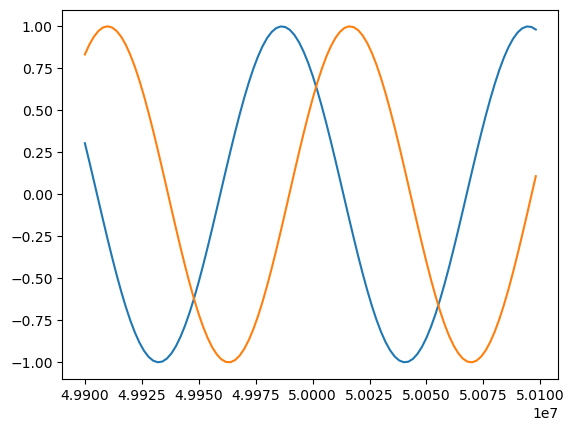

In [24]:
plt.plot(output_uv.freq_array, np.real(output_uv.data_array[0,:,0])/ np.max(output_uv.data_array))
plt.plot(output_uv.freq_array, np.real(np.exp(2 * np.pi * 1j * (np.sin(np.deg2rad(70)) * 3000 / 3e8 * output_uv.freq_array))))

In [14]:
np.real(np.exp(2 * np.pi * 1j * (np.cos(np.deg2rad(90)) * 3000 / 3e8 * output_uv.freq_array)))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
output_uv.uvw_array

array([[ 3.00000000e+03,  9.14865707e-11, -1.20426457e-10]])

In [16]:
uv.telescope.get_enu_antpos()

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.00000000e+03,  9.15179044e-11, -1.20394361e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [17]:
uv.telescope.antenna_positions

array([[ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10],
       [ 2.64188702e+03, -1.42141936e+03,  4.65661287e-10],
       [ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10],
       ...,
       [ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10],
       [ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10],
       [ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10]])

In [18]:
uv.telescope.check()

True

In [19]:
uv.telescope._mount_type

In [20]:
# get antennas positions in ECEF
telescope_ecef_xyz = Quantity(uv.telescope.location.geocentric).to_value("m")
antpos = uv.telescope.antenna_positions + telescope_ecef_xyz

# convert to East, North, Up (ENU) coords.
antpos = pyuvdata.utils.ENU_from_ECEF(antpos, center_loc=uv.telescope.location)

In [21]:
antpos

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.00000000e+03,  9.15179044e-11, -1.20394361e-10],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [22]:
np.shape(antpos)

(352, 3)

In [23]:
uv.telescope.antenna_positions

array([[ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10],
       [ 2.64188702e+03, -1.42141936e+03,  4.65661287e-10],
       [ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10],
       ...,
       [ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10],
       [ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10],
       [ 9.31322575e-10, -9.31322575e-10,  4.65661287e-10]])